<a href="https://colab.research.google.com/github/Soumi7/EY_GDS_Project/blob/main/Training_Intelligent_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intent Recognition with BERT using Keras and TensorFlow 2

In [1]:
!nvidia-smi

Tue Dec  8 19:10:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow-gpu >> /dev/null

In [4]:
!pip install --upgrade grpcio >> /dev/null

In [5]:
!pip install tqdm  >> /dev/null

In [6]:
!pip install bert-for-tf2 >> /dev/null

In [7]:
!pip install sentencepiece >> /dev/null

In [8]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Data


In [9]:
train = pd.read_csv("train.csv", encoding = "utf-8-sig")
valid = pd.read_csv("valid.csv", encoding = "utf-8-sig")
test = pd.read_csv("test.csv",encoding = "utf-8-sig")
folder =  pd.read_csv("folders.csv", encoding= "utf-8-sig")

In [10]:
train = train.append(valid).reset_index(drop=True)

In [11]:
train.shape

(34359, 2)

In [12]:
train.head()

,text,intent
0,We have dignity in a way in which no other ani...,Research
1,All members of the Audit Committee are indepen...,Coding Guidelines
2,if we want to change it from string to binary ...,Case Study
3,The users of price of Royal Enfield bikes will...,Financial Reports
4,d India income tax The income tax provisions f...,CompanyDetails


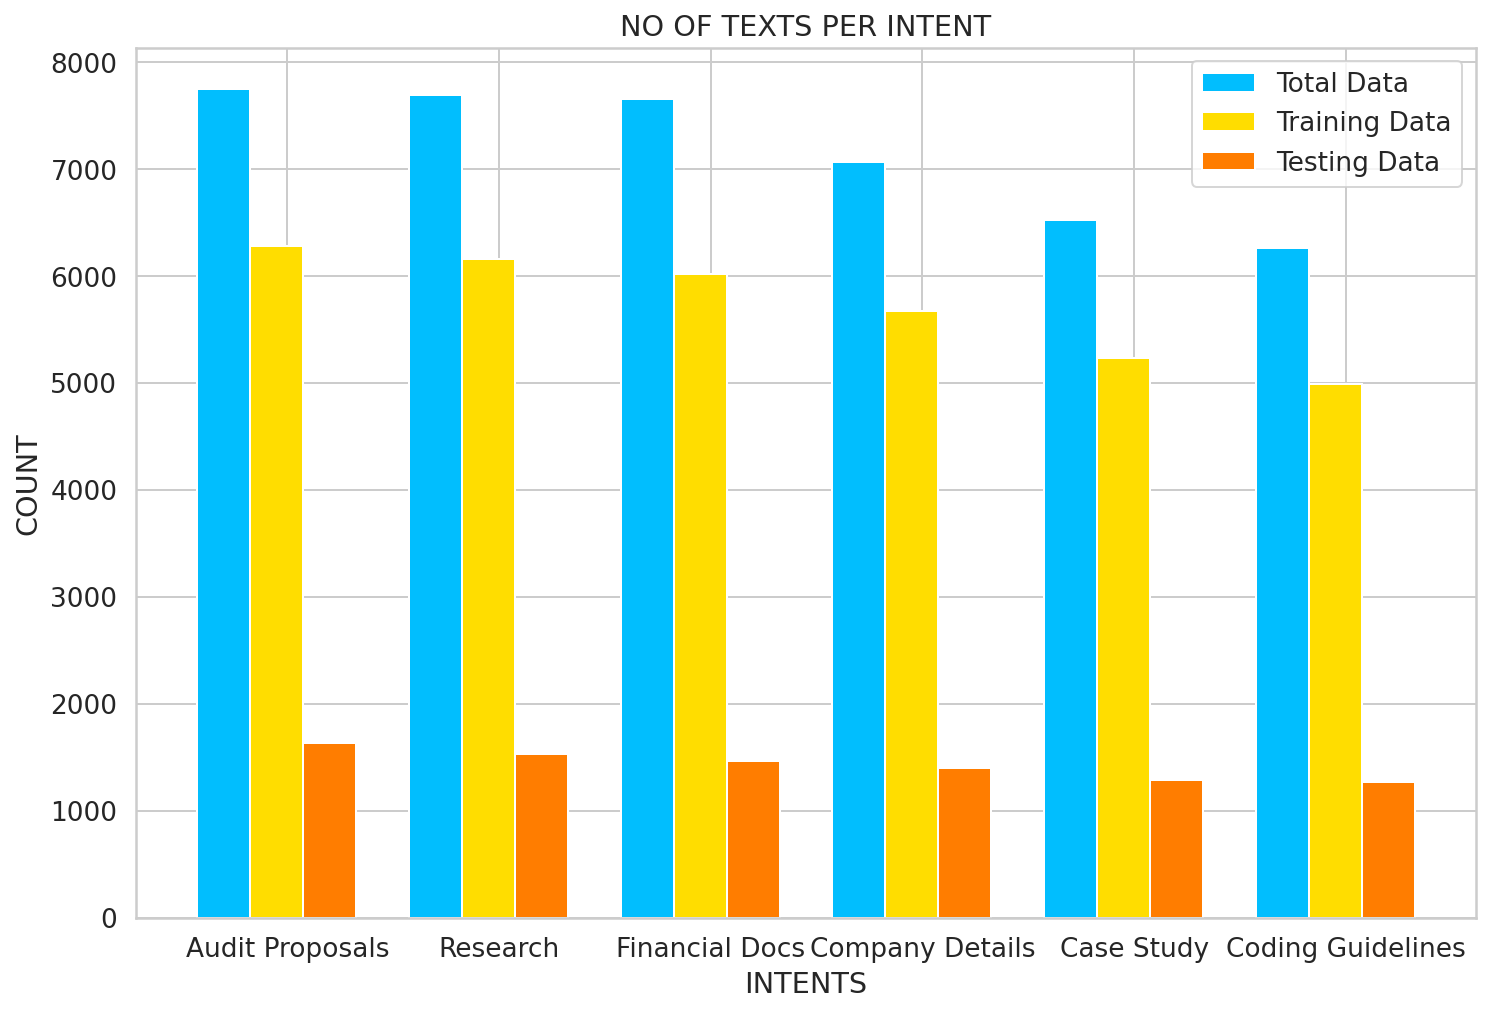

In [13]:
index = np.arange(6)
bar_width = 0.25

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

Total = ax.bar(index, folder["Intent"].value_counts(), bar_width,label="Total Data")
Training = ax.bar(index+bar_width, train["intent"].value_counts(),bar_width, label="Training Data")
Testing = ax.bar(index+bar_width+bar_width, test["intent"].value_counts(),bar_width, label="Testing Data")

ax.set_xlabel('INTENTS')
ax.set_ylabel('COUNT')
ax.set_title('NO OF TEXTS PER INTENT')
ax.set_xticks(index + bar_width+.1 / 2)
ax.set_xticklabels(["Audit Proposals", "Research", "Financial Docs", "Company Details", "Case Study", "Coding Guidelines"], )
ax.legend()


plt.savefig("/content/drive/MyDrive/EY_DATA/Total Intent Data.jpg")

plt.show()


In [30]:
folder.Intent.value_counts()

AuditProposals       7746
Research             7695
Financial Reports    7653
CompanyDetails       7067
Case Study           6528
Coding Guidelines    6260
Name: Intent, dtype: int64

# Intent Recognition with BERT

In [15]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-12-08 19:11:40--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.217.7.144, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  78.1MB/s    in 5.2s    

2020-12-08 19:11:46 (74.2 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [31]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [32]:
os.makedirs("model", exist_ok=True)

In [33]:
!mv uncased_L-12_H-768_A-12/ model

In [34]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [35]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    print("reached here")
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [36]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [39]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

## Training

In [40]:
classes = train.intent.unique().tolist()
print(classes)
data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

201it [00:00, 2002.96it/s]

<class 'pandas.core.series.Series'>
['Research', 'Coding Guidelines', 'Case Study', 'Financial Reports', 'CompanyDetails', 'AuditProposals']
reached here


34359it [00:16, 2094.00it/s]
8590it [00:04, 1986.38it/s]


max seq_len 1618


In [41]:
data.train_x.shape

(34359, 128)

In [42]:
data.train_x[0]

array([  101,  2057,  2031, 13372,  1999,  1037,  2126,  1999,  2029,
        2053,  2060,  4111,  2515,  2029,  2003,  2025,  2000,  2360,
        2008,  2060,  4176,  3768, 13372,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [43]:
data.train_y[0]

0

In [44]:
data.max_seq_len

128

In [45]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fc453177cc0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [46]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                

In [47]:
model.compile(
  optimizer=keras.optimizers.Adam(2e-5),
#   optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.1, nesterov=False)
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [48]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=64,
  shuffle=False,
  epochs = 10)

Epoch 1/10
484/484 [==============================] - 998s 2s/step - loss: 1.5423 - acc: 0.4846 - val_loss: 1.4183 - val_acc: 0.6211
Epoch 2/10
484/484 [==============================] - 1004s 2s/step - loss: 1.3500 - acc: 0.6908 - val_loss: 1.3228 - val_acc: 0.7159
Epoch 3/10
484/484 [==============================] - 1005s 2s/step - loss: 1.2915 - acc: 0.7505 - val_loss: 1.2999 - val_acc: 0.7413
Epoch 4/10
484/484 [==============================] - 1004s 2s/step - loss: 1.2645 - acc: 0.7780 - val_loss: 1.2878 - val_acc: 0.7535
Epoch 5/10
484/484 [==============================] - 1003s 2s/step - loss: 1.2411 - acc: 0.8016 - val_loss: 1.2850 - val_acc: 0.7573
Epoch 6/10
484/484 [==============================] - 1005s 2s/step - loss: 1.2265 - acc: 0.8158 - val_loss: 1.2745 - val_acc: 0.7675
Epoch 7/10
229/484 [=============>................] - ETA: 8:30 - loss: 1.2135 - acc: 0.8309

In [ ]:
!mkdir -p saved_model
model.save('/content/drive/MyDrive/EY_DATA/saved_model/ey_model3')

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/EY_DATA/saved_model/ey_model3')

In [ ]:
new_model.summary()

## Evaluation

In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.savefig("/content/drive/MyDrive/EY_DATA/Training.jpg")
plt.show();

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.savefig("/content/drive/MyDrive/EY_DATA/Test.jpg")
plt.show();

# Training and test accuracies

In [ ]:
_, train_acc = new_model.evaluate(data.train_x, data.train_y)
_, test_acc = new_model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

In [ ]:
y_pred = new_model.predict(data.test_x).argmax(axis=-1)
y_pred

In [ ]:
print(classification_report(data.test_y, y_pred, target_names=classes))

In [ ]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

In [ ]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.savefig("/content/drive/MyDrive/EY_DATA/Confusion Matrix.jpg")